In [1]:
!pip install torchcontrib
!pip install efficientnet_pytorch
!pip install pretrainedmodels
!pip install pytorch_toolbelt
!pip install torch_optimizer
!git clone https://github.com/4uiiurz1/pytorch-auto-augment > /dev/null
# !conda install -c conda-forge nvidia-apex --yes
# !conda install -c conda-forge/label/cf202003 nvidia-apex --yes
!pip install --upgrade pillow

  Created wheel for torchcontrib: filename=torchcontrib-0.0.2-py3-none-any.whl size=7532 sha256=238280fb06fe3c36e78cee391bb360dcb596f3c6fb799ad0cb820bf3282896ae
  Stored in directory: /root/.cache/pip/wheels/91/58/d0/f03811c3e34e1f14031294b5f30d8693689972af874d1225b8
Successfully built torchcontrib
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=4bc59bf08636d85291cebe709b3cfbad78f42f33c90a01ea703031a4ca041797
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
Successfully built efficientnet-pytorch
     |████████████████████████████████| 58 kB 1.8 MB/s eta 0:00:011
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=8626327dc1938b150c927ba28decbd316d13bb65e6a2d96b444311b61d9bd3b3
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built pretrainedm

     |████████████████████████████████| 40 kB 1.8 MB/s eta 0:00:011
Cloning into 'pytorch-auto-augment'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 26 (delta 1), reused 2 (delta 0), pack-reused 20
Unpacking objects: 100% (26/26), done.
     |████████████████████████████████| 2.2 MB 3.5 MB/s eta 0:00:01
ERROR: pytorch-toolbelt 0.3.2 has requirement Pillow<7.0,>=6.0, but you'll have pillow 7.2.0 which is incompatible.
ERROR: bokeh 2.1.1 has requirement tornado>=5.1, but you'll have tornado 5.0.2 which is incompatible.
  Attempting uninstall: pillow
    Found existing installation: Pillow 6.2.2
    Uninstalling Pillow-6.2.2:
      Successfully uninstalled Pillow-6.2.2


In [2]:
import os
import gc
gc.enable()
import sys
import math
sys.path.insert(0, './pytorch-auto-augment')
import time   
import random
from glob import glob
from datetime import datetime
from typing import List

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchvision
from torch import Tensor
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset

#import apex
import catalyst
import efficientnet_pytorch
import pytorch_toolbelt
from pytorch_toolbelt.modules.pooling import (GlobalMaxPool2d, 
                                              GWAP,
                                              GlobalAvgPool2d, 
                                              GlobalRankPooling, 
                                              GlobalWeightedAvgPool2d,
                                             )
import torch_optimizer as optim
import torchcontrib
from torchcontrib.optim import SWA
import albumentations as A
#from auto_augment import AutoAugment, Cutout
import pretrainedmodels
from albumentations.augmentations.functional import brightness_contrast_adjust, elastic_transform
import json
import sklearn
from pytorch_toolbelt.utils import count_parameters
from sklearn.model_selection import KFold
from catalyst.data.sampler import BalanceClassSampler
from torch.utils.data.sampler import SequentialSampler
from torch.autograd import Variable

import warnings
warnings.filterwarnings("ignore")

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
SEED = 2020
seed_everything(SEED)

### Dataset

In [4]:
from sklearn.model_selection import StratifiedKFold

In [5]:
train = pd.read_csv('../input/siim-isic-melanoma-classification/train.csv')
test = pd.read_csv('../input/siim-isic-melanoma-classification/test.csv')

train['kfold'] = -1
# train.sample(frac=1).reset_index(drop=True)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2020)
for fold, (idxT, idxV) in enumerate(skf.split(train.image_name, train.target)):
#     train.loc[train.loc[train.tfrecord.isin(idxV)].index,'kfold'] = fold
    train.loc[idxV,'fold'] = fold
train.fold = train.fold.astype(int)
train.to_csv('train_folds.csv',index=False)

### Augmentations Factory

In [6]:
class AdvancedHairAugmentation(A.ImageOnlyTransform):
    """
    Impose an image of a hair to the target image

    Args:
        hairs (int): maximum number of hairs to impose
        hairs_folder (str): path to the folder with hairs images
    """

    def __init__(self, hairs: int = 5, hairs_folder: str = "", always_apply=False, p=0.5):
        super(AdvancedHairAugmentation, self).__init__(always_apply, p)

        self.hairs = hairs
        self.hairs_folder = hairs_folder

    def apply(self, img, **params):
        """
        Args:
            img (PIL Image): Image to draw hairs on.

        Returns:
            PIL Image: Image with drawn hairs.
        """
        n_hairs = random.randint(0, self.hairs)
        
        if not n_hairs:
            return img
        
        height, width, _ = img.shape  # target image width and height
        hair_images = [im for im in os.listdir(self.hairs_folder) if 'png' in im]
        
        for _ in range(n_hairs):
            hair = cv2.imread(os.path.join(self.hairs_folder, random.choice(hair_images)))
            hair = cv2.flip(hair, random.choice([-1, 0, 1]))
            hair = cv2.rotate(hair, random.choice([0, 1, 2]))

            h_height, h_width, _ = hair.shape  # hair image width and height
            roi_ho = random.randint(0, img.shape[0] - hair.shape[0])
            roi_wo = random.randint(0, img.shape[1] - hair.shape[1])
            roi = img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width]

            # Creating a mask and inverse mask
            img2gray = cv2.cvtColor(hair, cv2.COLOR_BGR2GRAY)
            ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
            mask_inv = cv2.bitwise_not(mask)

            # Now black-out the area of hair in ROI
            img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)

            # Take only region of hair from hair image.
            hair_fg = cv2.bitwise_and(hair, hair, mask=mask)

            # Put hair in ROI and modify the target image
            dst = cv2.add(img_bg, hair_fg)

            img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width] = dst
                
        return img

    def __repr__(self):
        return f'{self.__class__.__name__}(hairs={self.hairs}, hairs_folder="{self.hairs_folder}")'
    
class DrawHair(A.ImageOnlyTransform):
    """
    Draw a random number of pseudo hairs

    Args:
        hairs (int): maximum number of hairs to draw
        width (tuple): possible width of the hair in pixels
    """

    def __init__(self, hairs:int = 4, always_apply=False, width:tuple = (1, 2),p=0.5):
        super(DrawHair, self).__init__(always_apply, p)
        self.hairs = hairs
        self.width = width

    def apply(self, img, **params):
        """
        Args:
            img (PIL Image): Image to draw hairs on.

        Returns:
            PIL Image: Image with drawn hairs.
        """
        if not self.hairs:
            return img
        
        width, height, _ = img.shape
        
        for _ in range(random.randint(0, self.hairs)):
            # The origin point of the line will always be at the top half of the image
            origin = (random.randint(0, width), random.randint(0, height // 2))
            # The end of the line 
            end = (random.randint(0, width), random.randint(0, height))
            color = (0, 0, 0)  # color of the hair. Black.
            cv2.line(img, origin, end, color, random.randint(self.width[0], self.width[1]))
        
        return img

    def __repr__(self):
        return f'{self.__class__.__name__}(hairs={self.hairs}, width={self.width})'
    
class Microscope(A.ImageOnlyTransform):
    """
    Cutting out the edges around the center circle of the image
    Imitating a picture, taken through the microscope

    Args:
        p (float): probability of applying an augmentation
    """

    def __init__(self, always_apply=False, p: float = 0.5):
        super(Microscope, self).__init__(always_apply, p)
        self.p = p

    def apply(self, img, **params):
        """
        Args:
            img (PIL Image): Image to apply transformation to.

        Returns:
            PIL Image: Image with transformation.
        """
        if random.random() < self.p:
            circle = cv2.circle((np.ones(img.shape) * 255).astype(np.uint8), # image placeholder
                        (img.shape[0]//2, img.shape[1]//2), # center point of circle
                        random.randint(img.shape[0]//2 - 3, img.shape[0]//2 + 15), # radius
                        (0, 0, 0), # color
                        -1)

            mask = circle - 255
            img = np.multiply(img, mask)
        
        return img

    def __repr__(self):
        return f'{self.__class__.__name__}(p={self.p})'
    
class IndependentRandomBrightnessContrast(A.ImageOnlyTransform):
    """ Change brightness & contrast independently per channels """

    def __init__(self, brightness_limit=0.2, contrast_limit=0.2, always_apply=False, p=0.5):
        super(IndependentRandomBrightnessContrast, self).__init__(always_apply, p)
        self.brightness_limit = A.to_tuple(brightness_limit)
        self.contrast_limit = A.to_tuple(contrast_limit)

    def apply(self, img, **params):
        img = img.copy()
        for ch in range(img.shape[2]):
            alpha = 1.0 + random.uniform(self.contrast_limit[0], self.contrast_limit[1])
            beta = 0.0 + random.uniform(self.brightness_limit[0], self.brightness_limit[1])
            img[..., ch] = brightness_contrast_adjust(img[..., ch], alpha, beta)

        return img

class BrightnessContrastDestroy(A.ImageOnlyTransform):
    def __init__(self, p=0.5):
        super().__init__(p=p)

    @property
    def targets(self):
        return {'image': self.apply, 'diagnosis': self.apply_to_diagnosis}

    def apply_to_diagnosis(self, diagnosis, **params):
        return 0

    def apply(self, img, alpha=0, beta=0, **params):
        from albumentations.augmentations.functional import brightness_contrast_adjust
        img = brightness_contrast_adjust(img, alpha=alpha, beta=beta)
        return img

    def get_params(self):
        return {'alpha': random.uniform(0.05, 0.25),
                'beta': random.uniform(-0.5, -0.75)}


class MakeTooBlurry(A.ImageOnlyTransform):
    def __init__(self, p=0.5):
        super().__init__(p=p)

    @property
    def targets(self):
        return {'image': self.apply, 'diagnosis': self.apply_to_diagnosis}

    def apply_to_diagnosis(self, diagnosis, **params):
        return 0

    def apply(self, img, blur_ksize=3, **params):
        img = cv2.boxFilter(img, ddepth=cv2.CV_8U, ksize=(blur_ksize, blur_ksize))
        return img

    def get_params(self):
        return {'blur_ksize': int(random.uniform(21, 32)) * 2 + 1}


class MakeTooBlurryMedian(A.ImageOnlyTransform):
    def __init__(self, p=0.5):
        super().__init__(p=p)

    @property
    def targets(self):
        return {'image': self.apply, 'diagnosis': self.apply_to_diagnosis}

    def apply_to_diagnosis(self, diagnosis, **params):
        return 0

    def apply(self, img, blur_ksize=3, **params):
        img = cv2.medianBlur(img, ksize=blur_ksize)
        return img

    def get_params(self):
        return {'blur_ksize': int(random.uniform(8, 16)) * 2 + 1}

def fancy_pca(img, alpha=0.1):
    orig_img = img.astype(float).copy()
    img = img / 255.0
    img_rs = img.reshape(-1, 3)
    img_centered = img_rs - np.mean(img_rs, axis=0)
    img_cov = np.cov(img_centered, rowvar=False)
    eig_vals, eig_vecs = np.linalg.eigh(img_cov)
    sort_perm = eig_vals[::-1].argsort()
    eig_vals[::-1].sort()
    eig_vecs = eig_vecs[:, sort_perm]
    m1 = np.column_stack((eig_vecs))
    m2 = np.zeros((3, 1))
    m2[:, 0] = alpha * eig_vals[:]
    add_vect = np.matrix(m1) * np.matrix(m2)
    for idx in range(3):  # RGB
        orig_img[..., idx] += add_vect[idx] * 255
    orig_img = np.clip(orig_img, 0.0, 255.0)
    orig_img = orig_img.astype(np.uint8)
    return orig_img

class FancyPCA(A.ImageOnlyTransform):
    def __init__(self, alpha_std=0.1, p=0.5):
        super().__init__(p=p)
        self.alpha_std = alpha_std

    def apply(self, img, alpha=0.1, **params):
        img = fancy_pca(img, alpha)
        return img

    def get_params(self):
        return {'alpha': random.gauss(0, self.alpha_std)}
    
def clahe_preprocessing(image, clip_limit=4.0, tile_grid_size=(18, 18)):
    image_norm = image.copy()

    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    image_norm[:, :, 0] = clahe.apply(image[:, :, 0])
    image_norm[:, :, 1] = clahe.apply(image[:, :, 1])
    image_norm[:, :, 2] = clahe.apply(image[:, :, 2])

    # image_norm = cv2.addWeighted(image, 0.5, image_norm, 0.5, 0)
    return image_norm

class ChannelIndependentCLAHE(A.ImageOnlyTransform):
    def __init__(self, p=1.0):
        super().__init__(p=p)

    def apply(self, img, **params):
        return clahe_preprocessing(img)

    def get_transform_init_args_names(self):
        return tuple()

In [7]:
def get_none_augmentations(image_size):
    return A.NoOp()


def get_light_augmentations(image_size):
    return A.Compose([
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1,
                           rotate_limit=15,
                           border_mode=cv2.BORDER_CONSTANT, value=0),
        A.RandomSizedCrop(min_max_height=(int(image_size[0] * 0.85), image_size[0]),
                          height=image_size[0],
                          width=image_size[1], p=0.3),
        Microscope(p=0.3),
        # Brightness/contrast augmentations
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.25,
                                       contrast_limit=0.2),
            IndependentRandomBrightnessContrast(brightness_limit=0.1,
                                                contrast_limit=0.1),
            A.RandomGamma(gamma_limit=(75, 125)),
            A.NoOp()
        ]),
        A.OneOf([
            ChannelIndependentCLAHE(p=0.5),
            A.CLAHE(),
            A.NoOp()
        ]),
        A.HorizontalFlip(p=0.5),
    ])


def get_medium_augmentations(image_size):
    return A.Compose([
        A.OneOf([
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1,
                               rotate_limit=15,
                               border_mode=cv2.BORDER_CONSTANT, value=0),
            A.OpticalDistortion(distort_limit=0.11, shift_limit=0.15,
                                border_mode=cv2.BORDER_CONSTANT,
                                value=0),
            A.NoOp()
        ]),
        Microscope(p=0.3),
        A.RandomSizedCrop(min_max_height=(int(image_size[0] * 0.75), image_size[0]),
                          height=image_size[0],
                          width=image_size[1], p=0.3),
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.5,
                                       contrast_limit=0.4),
            IndependentRandomBrightnessContrast(brightness_limit=0.25,
                                                contrast_limit=0.24),
            A.RandomGamma(gamma_limit=(50, 150)),
            A.NoOp()
        ]),
        A.OneOf([
            FancyPCA(alpha_std=4),
            A.RGBShift(r_shift_limit=20, b_shift_limit=15, g_shift_limit=15),
            A.HueSaturationValue(hue_shift_limit=5,
                                 sat_shift_limit=5),
            A.NoOp()
        ]),
        A.OneOf([
            ChannelIndependentCLAHE(p=0.5),
            A.CLAHE(),
            A.NoOp()
        ]),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5)
    ])

def get_hard_augmentations(image_size):
    return A.Compose([
        A.OneOf([
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1,
                               rotate_limit=45,
                               border_mode=cv2.BORDER_CONSTANT, value=0),
            A.ElasticTransform(alpha_affine=0,
                               alpha=35,
                               sigma=5,
                               border_mode=cv2.BORDER_CONSTANT,
                               value=0),
            A.OpticalDistortion(distort_limit=0.11, shift_limit=0.15,
                                border_mode=cv2.BORDER_CONSTANT,
                                value=0),
            A.GridDistortion(border_mode=cv2.BORDER_CONSTANT,
                             value=0),
            A.NoOp()
        ]),

        A.OneOf([
            Microscope(p=0.3),

            A.RandomSizedCrop(min_max_height=(int(image_size[0] * 0.75), image_size[0]),
                              height=image_size[0],
                              width=image_size[1], p=0.3),
            A.NoOp()
        ]),

        A.ISONoise(p=0.5),
        A.JpegCompression(p=0.3, quality_lower=75),

        # Brightness/contrast augmentations
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.5,
                                       contrast_limit=0.4),
            IndependentRandomBrightnessContrast(brightness_limit=0.25,
                                                contrast_limit=0.24),
            A.RandomGamma(gamma_limit=(50, 150)),
            A.NoOp()
        ]),

        A.OneOf([
            FancyPCA(alpha_std=6),
            A.RGBShift(r_shift_limit=40, b_shift_limit=30, g_shift_limit=30),
            A.HueSaturationValue(hue_shift_limit=10,
                                 sat_shift_limit=10),
            A.ToGray(p=0.2),
            A.NoOp()
        ]),

        # Add preprocessing method as an augmentation
        ChannelIndependentCLAHE(p=0.5),

        A.OneOf([
            A.ChannelDropout(p=0.2),
            A.CoarseDropout(p=0.1, max_holes=2, max_width=256, max_height=256, min_height=16, min_width=16),
            A.RandomGridShuffle(p=0.3),
            A.NoOp()
        ]),

        A.RandomGridShuffle(p=0.3),
        DrawHair(p=0.3),

        # D4
        A.Compose([
            A.RandomRotate90(),
            A.Transpose()
        ])
    ])


def get_train_transform(image_size, augmentation=None):
    if augmentation is None:
        augmentation = 'none'

    LEVELS = {
        'none': get_none_augmentations,
        'light': get_light_augmentations,
        'medium': get_medium_augmentations,
        'hard': get_hard_augmentations,
    }

    assert augmentation in LEVELS.keys(), f"Augmentation {augmentation} not found."
    augmentation = LEVELS[augmentation](image_size)

    longest_size = max(image_size[0], image_size[1])
    return A.Compose([
        A.LongestMaxSize(longest_size, interpolation=cv2.INTER_CUBIC),
        A.PadIfNeeded(image_size[0], image_size[1],
                      border_mode=cv2.BORDER_CONSTANT, value=0),
        augmentation,
        #A.Normalize()
    ])

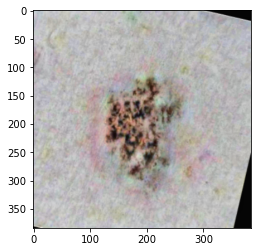

In [8]:
train_transforms = get_train_transform([384,384],'light')
image = cv2.cvtColor(cv2.imread('../input/jpeg-isic2019-384x384/train/ISIC_0000010.jpg', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
image_sample = {'image':image}
image_sample = train_transforms(**image_sample)
image = image_sample['image']
plt.imshow(image)

### Data Retriever Factory

In [9]:
def get_class_names():
    CLASS_NAMES = [
        'benign',
        'malignant'
    ]
    return CLASS_NAMES

class MelanomaTrainDataset(Dataset):
    def __init__(self, dataframe:pd.DataFrame, 
                 dataset_dir:str, 
                 classes:int,
                 fold_idx:int=0,
                 transforms=None,
                 do_one_hot:bool=True,
                 meta_features=False
                ):
        self.df = dataframe
        self.image_ids = self.df.image_name.values
        self.targets = self.df.target.values
        if self.targets is not None:
            targets = np.array(self.targets)
            unique_targets = set(targets)
            if len(unique_targets.difference({0, 1})):
                raise ValueError('Unexpected targets in Y ' + str(unique_targets))
        self.dataset_dir = dataset_dir
        self.fold_idx = fold_idx
        self.transforms = transforms
        self.classes = classes
        self.do_one_hot = do_one_hot
        self.meta_features = meta_features
        
    def __len__(self):
        return len(self.image_ids)
        
    def __getitem__(self, index):
        image_id = self.image_ids[index]
        target = self.targets[index]
        if self.do_one_hot:
            one_hot_target = torch.zeros(self.classes, dtype=torch.float32)
            one_hot_target[target] = 1.
            target = one_hot_target        
        image_path = f'{self.dataset_dir}/{image_id}.jpg'
        image = cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #print(image.shape)
        #image = image / 255.0
        #print(image.shape)
        image = Image.fromarray(image)
        
        if self.transforms is not None:
            image = self.transforms(image)
        
        data = {'images': image,
                'targets': target}
        
        height, width = image.shape[:2]
        if self.meta_features:
            log_height = math.log(height)
            log_width = math.log(width)
            aspect_ratio = log_height / log_width
            mean = np.mean(image, axis=(0, 1))
            meta_features = np.array([
                log_height,
                log_width,
                aspect_ratio,
                mean[0],
                mean[1],
                mean[2]
            ])
            data['meta_features'] = meta_features
        return data
    
    def get_labels(self):
        return list(self.targets)

In [10]:
train_transforms = transforms.Compose([
        #transforms.ToPILImage(),
        transforms.Resize((384, 384)),
#         transforms.RandomAffine(
#             degrees=(-180, 180),
#             scale=(0.8889, 1.0),
#             shear=(-36,36),
#         ),
        transforms.CenterCrop(384),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ColorJitter(
            brightness=0,
            contrast=(0.9,1.1),
            saturation=0,
            hue=0),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

torch.Size([3, 384, 384])
0


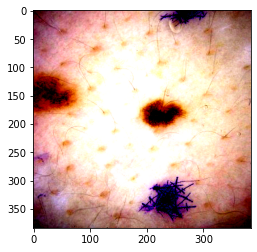

In [11]:
fold = 0

DIR = '../input/jpeg-melanoma-384x384/train'

train_dataset = MelanomaTrainDataset(dataframe = train[train.kfold!=fold],
                                     dataset_dir=DIR,
                                     classes=len(get_class_names()),
                                     fold_idx=fold,
                                     do_one_hot=False,
                                     transforms=train_transforms,
                                     meta_features=False
                                    )

data = train_dataset[7]
print(data["images"].shape)
print(data['targets'])
images = data['images'].permute(1,2,0)
plt.imshow(images)

### Loss Factory

In [12]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.size_average = size_average

    def forward(self, input, target):
        """
        :param input: shape N * C
        :param target: shape N * C
        :return: loss
        """
        if isinstance(self.alpha, (float, int)):
            self.alpha = (self.alpha * torch.ones((target.size(1), 2))).cuda()
        if isinstance(self.alpha, list):
            self.alpha = torch.stack((torch.tensor(self.alpha), 1 - torch.tensor(self.alpha)), dim=1).cuda()
        pt = Variable(torch.sigmoid(input)).cuda()
        # loss = nn.BCELoss(reduction="none")(pt, target)
        loss = nn.BCEWithLogitsLoss(reduction="none")(input, target)
        loss = self.alpha[:, 0] * target * torch.pow(1 - pt, self.gamma) * loss + self.alpha[:, 1] * (
                    1 - target) * torch.pow(pt, self.gamma) * loss

        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

# class FocalLoss(nn.Module):
#     def __init__(self, gamma=0.5, alpha=2, size_average=True):
#         super(FocalLoss, self).__init__()
#         self.gamma = gamma
#         self.alpha = alpha
#         if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
#         if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
#         self.size_average = size_average

#     def forward(self, input, target):
#         if input.dim()>2:
#             input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
#             input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
#             input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
#         target = target.view(-1,1)

#         logpt = F.log_softmax(input)
#         logpt = logpt.gather(1,target)
#         logpt = logpt.view(-1)
#         pt = Variable(logpt.data.exp())

#         if self.alpha is not None:
#             if self.alpha.type()!=input.data.type():
#                 self.alpha = self.alpha.type_as(input.data)
#             at = self.alpha.gather(0,target.data.view(-1))
#             logpt = logpt * Variable(at)

#         loss = -1 * (1-pt)**self.gamma * logpt
#         if self.size_average: return loss.mean()
#         else: return loss.sum()

# class FocalLoss(nn.Module):
#     def __init__(self, focusing_param=2, balance_param=0.25):
#         super(FocalLoss, self).__init__()
#         self.focusing_param = focusing_param
#         self.balance_param = balance_param

#     def forward(self, output, target):
#         cross_entropy = F.cross_entropy(output, target)
#         cross_entropy_log = torch.log(cross_entropy)
#         logpt = - F.cross_entropy(output, target)
#         pt = torch.exp(logpt)

#         focal_loss = -((1 - pt) ** self.focusing_param) * logpt
#         balanced_focal_loss = self.balance_param * focal_loss

#         return balanced_focal_loss

In [13]:
class LabelSmoothing(nn.Module):
    def __init__(self, smoothing = 0.05):
        super(LabelSmoothing, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing

    def forward(self, x, target):
        if self.training:
            x = x.float()
            target = target.float()
            logprobs = torch.nn.functional.log_softmax(x, dim = -1)
            nll_loss = -logprobs * target
            nll_loss = nll_loss.sum(-1)
            smooth_loss = -logprobs.mean(dim=-1)
            loss = self.confidence * nll_loss + self.smoothing * smooth_loss
            return loss.mean()
        else:
            return torch.nn.functional.cross_entropy(x, target)
        
def soft_crossentropy(input: torch.Tensor,
                      target: torch.Tensor,
                      ignore_index=None,
                      smooth_factor=0.01,
                      reduction='mean'):
    if ignore_index is not None:
        mask = target != ignore_index
        target = target[mask]
        input = input[mask]

    if not len(target):
        return torch.tensor(0.).type_as(input).to(input.device)

    n_class = input.size(1)
    one_hot = torch.zeros_like(input).scatter(1, target.view(-1, 1), 1)
    one_hot = one_hot * (1 - smooth_factor) + (1 - one_hot) * smooth_factor / (n_class - 1)
    log_prb = F.log_softmax(input, dim=1)
    loss = -(one_hot * log_prb).sum(dim=1)
    if reduction == 'mean':
        loss = loss.mean()
    if reduction == 'sum':
        loss = loss.sum()
    return loss

class SoftCrossEntropyLoss(nn.Module):
    def __init__(self, smooth_factor=0.01, ignore_index=None, reduction='mean'):
        super().__init__()
        self.smooth_factor = smooth_factor
        self.ignore_index = ignore_index
        self.reduction = reduction

    def forward(self, input: torch.Tensor, target: torch.Tensor):
        return soft_crossentropy(input, target,
                                 ignore_index=self.ignore_index,
                                 smooth_factor=self.smooth_factor,
                                 reduction=self.reduction)
    
class SmoothLoss(nn.Module):
    def __init__(self):
       super(SmoothLoss, self).__init__()
    def forward(self, pred, target):
       pred = pred.log_softmax(dim=1)
       return torch.mean(torch.sum(-target * pred, dim=1))

### Optimizer Factory

In [14]:
def sgd(parameters, lr=0.001, momentum=0.9, weight_decay=0, nesterov=True, **_):
  return optim.SGD(parameters, 
                   lr=lr, 
                   momentum=momentum, 
                   weight_decay=weight_decay,
                   nesterov=nesterov)

def adam(parameters, lr=0.001, betas=(0.9, 0.999), weight_decay=0, amsgrad=False, **_):
  if isinstance(betas, str):
    betas = eval(betas)
  return torch.optim.Adam(parameters, 
                          lr=lr, 
                          betas=betas, 
                          weight_decay=weight_decay,
                          amsgrad=amsgrad)

def adamw(paraneters, lr=1e-3, betas=(0.9, 0.999), eps=1e-3, weight_decay=0, amsgrad=False):
    if isinstance(betas, str):
        betas = eval(betas)
    return torch.optim.AdamW(parameters,
                            lr=lr,
                            betas=betas,
                            eps=eps,
                            weight_decay=weight_decay,
                            amsgrad=amsgrad)

def qhadamw(paraneters, lr=1e-3, betas=(0.995, 0.999), nus=(0.7, 1.0), weight_decay=0.0, eps=1e-8):
    if isinstance(betas, str):
        betas = eval(betas)
    if isinstance(nus, str):
        nus = eval(nus)
    return optim.QHAdam(parameters, 
                        lr=lr, 
                        betas=betas, 
                        nus=nus, 
                        weight_decay=weight_decay, 
                        eps=eps)

def radam(parameters, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
    if isinstance(betas, str):
        betas = eval(betas)
    return optim.RAdam(parameters,
                      lr=lr,
                      betas=betas,
                      eps=eps,
                      weight_decay=weight_decay)

def lamb(parameters, lr=1e-3, betas=(0.9, 0.999), eps=1e-6, weight_decay=0, adam=False):
    if isinstance(betas, str):
        betas = eval(betas)
    return optim.Lamb(parameters,
                     lr=lr,
                     betas=betas,
                     eps=eps,
                     weight_decay=weight_decay,
                     adam=adam)

def ranger(parameters, lr=1e-3, alpha=0.5, k=6, N_sma_threshhold=5, betas=(.95, 0.999), eps=1e-5, weight_decay=0):
    if isinstance(betas, str):
        betas = eval(betas)
    return optim.Ranger(parameters,
                       lr=lr,
                       k=k,
                       N_sma_threshhold=N_sma_threshhold,
                       betas=betas,
                       eps=eps,
                       weight_decay=weight_decay)

### Model Factory

#### Encoder Factory

In [15]:
class EncoderHeadModel(nn.Module):
    def __init__(self, encoder, head):
        super(EncoderHeadModel, self).__init__()
        self.encoder = encoder
        self.head = head

    @property
    def features_size(self):
        return self.head.features_size

    def forward(self, image):
        feature_maps = self.encoder(image)
        result = self.head(feature_maps)
        return result 
    
class SEResNext50_32x4dEncoder(nn.Module):
    def __init__(self, pretrained, path):
        super(SEResNext50_32x4dEncoder, self).__init__()
        self.base = pretrainedmodels.__dict__['se_resnext50_32x4d'](pretrained=None)
        if pretrained:
            self.base.load_state_dict(
                torch.load(path)
            )
        self.output_filters = [2048]
        
    def forward(self, x):
        x = self.base.features(x)
        return [x]
    
class SEResNext101_32x4dEncoder(nn.Module):
    def __init__(self, pretrained, path):
        super(SEResNext101_32x4dEncoder, self).__init__()
        self.base = pretrainedmodels.__dict__['se_resnext101_32x4d'](pretrained=None)
        if pretrained:
            self.base.load_state_dict(
                torch.load(path)
            )
        self.output_filters = [2048]
    
    def forward(self, x):
        x = self.base.features(x)
        return [x]

class InceptionV4Encoder(nn.Module):
    def __init__(self, pretrained, path):
        self.base = pretrainedmodels.__dict__['inceptionv4'](pretrained=pretrained)
        super(InceptionV4Encoder, self).__init__()
        self.output_filters = [1536]
        
    def forward(self, x):
        x = self.base.features(x)
        return [x]
    
class InceptionResnetV2Encoder(nn.Module):
    def __init__(self, pretrained, path):
        self.base = pretrainedmodels.__dict__['inceptionresnetv2'](pretrained=pretrained)
        super(InceptionResnetV2Encoder, self).__init__()
        self.output_filters = [1536]
        
    def forward(self, x):
        x = self.base.features(x)
        return [x]

#### Head Factory

In [16]:
def gem(x, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)

class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = Parameter(torch.ones(1)*p)
        self.eps = eps
    def forward(self, x):
        return gem(x, p=self.p, eps=self.eps)       
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

class GeneralizedMeanPoolingHead(nn.Module):
    def __init__(self, feature_maps, num_classes:int, dropout=0, multisample_dropout=False):
        super(GeneralizedMeanPoolingHead, self).__init__()
        self.features_size = feature_maps[-1]
        self.drop_prob = dropout
        self.multisample_dropout = multisample_dropout 
        self.meanpool = GeM()
        self.dropout = nn.Dropout(dropout)
        self.logits = nn.Linear(self.features_size, num_classes)
    
    def forward(self, feature_maps):
        features = self.meanpool(feature_maps[-1])
        features = features.view(features.size(0), features.size(1))
        if self.multisample_dropout:
            logits = torch.mean(
                torch.stack(
                    [self.logits(self.dropout(features)) for _ in range(5)],
                    dim=0,
                ),
                dim=0,
            )
        elif self.drop_prob != 0:
            features = self.dropout(features)
            logits = self.logits(features)
        else:
            logits = self.logits(features)
        return {
            'features': features,
            'logits': logits
        }
    
class GlobalAvgPoolHead(nn.Module):
    def __init__(self, feature_maps, num_classes: int, dropout=0., multisample_dropout=False):
        super(GlobalAvgPoolHead, self).__init__()
        self.features_size = feature_maps[-1]
        self.drop_prob = dropout
        self.multisample_dropout = multisample_dropout 
        self.avgpool = GlobalAvgPool2d()
        self.dropout = nn.Dropout(dropout)
        self.logits = nn.Linear(self.features_size, num_classes)

    def forward(self, feature_maps):
        features = self.avgpool(feature_maps[-1])
        features = features.view(features.size(0), features.size(1))
        if self.multisample_dropout:
            logits = torch.mean(
                torch.stack(
                    [self.logits(self.dropout(features)) for _ in range(5)],
                    dim=0,
                ),
                dim=0,
            )
        elif self.drop_prob != 0:
            features = self.dropout(features)
            logits = self.logits(features)
        else:
            logits = self.logits(features)
        return {
            'features': features,
            'logits': logits
        }
    
class GlobalWeightedAvgPoolHead(nn.Module):
    def __init__(self, feature_maps, num_classes: int, dropout=0., multisample_dropout=False):
        super(GlobalWeightedAvgPoolHead, self).__init__()
        self.features_size = feature_maps[-1]
        self.drop_prob = dropout
        self.multisample_dropout = multisample_dropout 
        self.gwap = GWAP(self.features_size)
        self.dropout = nn.Dropout(dropout)
        self.logits = nn.Linear(self.features_size, num_classes)

    def forward(self, feature_maps):
        features = feature_maps[-1]
        features = self.gwap(features)
        features = features.view(features.size(0), features.size(1))
        if self.multisample_dropout:
            logits = torch.mean(
                torch.stack(
                    [self.logits(self.dropout(features)) for _ in range(5)],
                    dim=0,
                ),
                dim=0,
            )
        elif self.drop_prob != 0:
            features = self.dropout(features)
            logits = self.logits(features)
        else:
            logits = self.logits(features)

        return {
            'features': features,
            'logits': logits
        }

class GlobalMaxPoolHead(nn.Module):
    def __init__(self, feature_maps, num_classes: int, dropout=0., reduction=8, multisample_dropout=False):
        super(GlobalMaxPoolHead, self).__init__()
        self.features_size = feature_maps[-1] // reduction
        self.drop_prob = dropout
        self.multisample_dropout = multisample_dropout 
        self.bottleneck = nn.Sequential(
            nn.Conv2d(feature_maps[-1], self.features_size, kernel_size=1, bias=False),
            nn.BatchNorm2d(self.features_size),
            nn.ReLU(inplace=True))
        self.maxpool = GlobalMaxPool2d()
        self.dropout = nn.Dropout(dropout)
        self.logits = nn.Linear(self.features_size, num_classes)

    def forward(self, feature_maps):
        features = feature_maps[-1]
        features = self.bottleneck(features)
        features = self.maxpool(features)
        features = features.view(features.size(0), features.size(1))
        if self.multisample_dropout:
            logits = torch.mean(
                torch.stack(
                    [self.logits(self.dropout(features)) for _ in range(5)],
                    dim=0,
                ),
                dim=0,
            )
        elif self.drop_prob != 0:
            features = self.dropout(features)
            logits = self.logits(features)
        else:
            logits = self.logits(features)
            
        return {
            'features': features,
            'logits': logits,
        }

class GlobalMaxPoolHeadV2(nn.Module):
    def __init__(self, feature_maps, num_classes: int, dropout=0.,multisample_dropout=False):
        super(GlobalMaxPoolHeadV2, self).__init__()
        self.features_size = feature_maps[-1]
        self.drop_prob = dropout
        self.multisample_dropout = multisample_dropout 
        self.maxpool = GlobalMaxPool2d()
        self.dropout = nn.Dropout(dropout)
        self.logits = nn.Linear(self.features_size, num_classes)

    def forward(self, feature_maps):
        features = self.maxpool(feature_maps[-1])
        features = features.view(features.size(0), features.size(1))
        if self.multisample_dropout:
            logits = torch.mean(
                torch.stack(
                    [self.logits(self.dropout(features)) for _ in range(5)],
                    dim=0,
                ),
                dim=0,
            )
        elif self.drop_prob != 0:
            features = self.dropout(features)
            logits = self.logits(features)
        else:
            logits = self.logits(features)
        return {
            'features': features,
            'logits': logits
        }

### Scheduler Factory

In [17]:
def step(optimizer, step_size=80, gamma=0.1, **_):
  return lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

def one_cycle(optimizer,  num_epochs, **_):
    return lr_scheduler.OneCycleLR(optimizer,
                                   lr_range=(lr, 1e-6, 1e-5),
                                   num_steps=num_epochs,
                                   warmup_fraction=0.05, 
                                   decay_fraction=0.1)

def multi_step(optimizer, milestones=[500, 5000], gamma=0.1, **_):
  if isinstance(milestones, str):
    milestones = eval(milestones)
  return lr_scheduler.MultiStepLR(optimizer, milestones=milestones,
                                  gamma=gamma)


def exponential(optimizer, gamma=0.995, **_):
  return lr_scheduler.ExponentialLR(optimizer, gamma=gamma)


def none(optimizer, **_):
  return lr_scheduler.StepLR(optimizer, step_size=10000000)


def reduce_lr_on_plateau(optimizer, **params):
  return lr_scheduler.ReduceLROnPlateau(optimizer, 
                                        mode='max',
                                        factor=0.8,
                                        patience=2,
                                        verbose=False, 
                                        threshold=0.0001,
                                        threshold_mode='rel',
                                        cooldown=0, 
                                        min_lr=1e-8,
                                        eps=1e-3)

def cosine(optimizer, T_max=10, eta_min=1e-6, **_):
  print('cosine annealing, T_max: {}, eta_min: {}'.format(T_max, eta_min))
  return lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)

### Metrics Factory

In [18]:
import sklearn
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


class RocAucMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.y_true = np.array([0,1])
        self.y_pred = np.array([0.5,0.5])
        self.score = 0

    def update(self, y_true, y_pred):
        y_true = y_true.cpu().numpy().argmax(axis=1).clip(min=0, max=1).astype(int)
        y_pred = nn.functional.softmax(y_pred, dim=1).data.cpu().numpy()[:,1]
        self.y_true = np.hstack((self.y_true, y_true))
        self.y_pred = np.hstack((self.y_pred, y_pred))
        self.score = sklearn.metrics.roc_auc_score(self.y_true, self.y_pred)

    @property
    def avg(self):
        return self.score

class APScoreMeter(RocAucMeter):
    def __init__(self):
        super(APScoreMeter, self).__init__()

    def update(self, y_true, y_pred):
        y_true = y_true.cpu().numpy().argmax(axis=1).clip(min=0, max=1).astype(int)
        y_pred = nn.functional.softmax(y_pred, dim=1).data.cpu().numpy()[:,1]
        self.y_true = np.hstack((self.y_true, y_true))
        self.y_pred = np.hstack((self.y_pred, y_pred))
        self.score = sklearn.metrics.average_precision_score(self.y_true, self.y_pred)

### Factory

In [19]:
def get_model(model_name, num_classes, pretrained=True, dropout=0.0, multisample_dropout=False, freeze_bn=False, **kwargs):
    keys = model_name.split('_')
    if len(keys) == 2:
        encoder_name, head_name = keys
        model = 'baseline'
    else:
        model, encoder_name, head_name = keys
    ENCODERS = {
        'inceptionv4':InceptionV4Encoder,
        'inceptionresnetv2':InceptionResnetV2Encoder,
        'seresnext50':SEResNext50_32x4dEncoder,
        'seresnext101':SEResNext101_32x4dEncoder
    }
    HEADS = {
        'gem':GeneralizedMeanPoolingHead,
        'gap':GlobalAvgPoolHead,
        'gwap':GlobalWeightedAvgPoolHead,
        'max':GlobalMaxPoolHead,
        'max2':GlobalMaxPoolHeadV2
    }
    MODELS = {
        'baseline':EncoderHeadModel
    }
    PATHS = {
        'inceptionv4': '../input/pretrained-model-weights-pytorch/inceptionv4-8e4777a0.pth',
        'inceptionresnetv2': '../input/pretrained-model-weights-pytorch/inceptionresnetv2-520b38e4.pth',
        'seresnext50': '../input/pretrained-model-weights-pytorch/se_resnext50_32x4d-a260b3a4.pth',
        'seresnext101': '../input/pretrained-model-weights-pytorch/se_resnext101_32x4d-3b2fe3d8.pth'
    }
    pretrained_path = PATHS[encoder_name]
    encoder = ENCODERS[encoder_name](pretrained=pretrained, path=pretrained_path)
    head = HEADS[head_name](feature_maps=encoder.output_filters, 
                            num_classes=num_classes, 
                            dropout=dropout,
                            multisample_dropout=multisample_dropout)
    model = MODELS[model](encoder=encoder, head=head)
    if freeze_bn:
        for m in model.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.weight.requires_grad = False
                m.bias.requires_grad = False
    return model

def get_loss(loss_name, **loss_params):
    LOSSES = {
        'focal':FocalLoss,
        'labelsmoothing':LabelSmoothing,
        'crossentropy':SoftCrossEntropyLoss,
        'smooth':SmoothLoss
    }
    criterion = LOSSES[loss_name](**loss_params)
    return criterion

def get_optimizer(optimizer_name: str, optimizer_parameters, learning_rate: float, weight_decay=0.001, **kwargs):
    OPTIMIZERS = {
        'sgd':sgd,
        'adam':adam,
        'adamw':adamw,
        'qhadamw':qhadamw,
        'radam':radam,
        'lamb':lamb,
        'ranger':ranger
    }
    optimizer = OPTIMIZERS[optimizer_name](parameters=optimizer_parameters, 
                                           lr=learning_rate,
                                           weight_decay=weight_decay,
                                           **kwargs
                                          )
    return optimizer

def get_scheduler(scheduler_name, optimizer, **scheduler_params):
    SCHEDULERS = {
        'step':step,
        'multi_step':multi_step,
        'exponential':exponential,
        'none':none,
        'reduce_lr_on_plateau':reduce_lr_on_plateau,
        'cosine':cosine,
        'one_cycle':one_cycle
    }
    scheduler = SCHEDULERS[scheduler_name](optimizer, **scheduler_params)
    return scheduler

### Configuration

In [ ]:
class Config():
    def __init__(self):
        self.epochs=20
        self.batch_size=16
        self.image_size=384
        self.aug='light'
        
        self.verbose=True
        self.log_step=1
        self.num_workers=4
        
        self.model_name = 'baseline_seresnext101_gap'
        self.loss = 'labelsmoothing'
        self.optimizer = 'radam'
        self.scheduler = 'cosine'
        
        self.checkpoint_prefix = f'{self.model_name}_{self.image_size}_{self.aug}'
        self.checkpoint_prefix += f'_{self.loss}'
        self.checkpoint_prefix += f'_{self.optimizer}'
        self.checkpoint_prefix += f'_{self.scheduler}'
        self.checkpoint_prefix += f'_{self.epochs}'
        self.checkpoint_prefix += f'_{self.batch_size}'
    
        self.log_dir=f'{self.checkpoint_prefix}/logs'
        self.log_path = os.path.join(self.log_dir, 'log.txt')
        self.config_path = f'{self.checkpoint_prefix}/config'
        self.config_fname = os.path.join(self.config_path, 'config.json')
        
        # Model Params
        self.num_classes = len(get_class_names())
        self.pretrained = 'imagenet'
        self.dropout = 0.2
        self.multisample_dropout = True
        self.freeze_bn = True
        
        self.model_params = dict(
            model_name=self.model_name,
            num_classes=self.num_classes,
            pretrained=self.pretrained,
            dropout=self.dropout,
            multisample_dropout=self.multisample_dropout,
            freeze_bn=self.freeze_bn
        )
        
        # Loss Params
        if self.loss=='labelsmoothing':
            self.smoothing=0.05
            self.loss_params = dict(
                smoothing=self.smoothing
            )
        elif self.loss == 'focal':
            self.gamma=2 
            self.alpha=1 
            self.size_average=True
            self.loss_params = dict(
                gamma=self.gamma,
                alpha=self.alpha,
                size_average=self.size_average
            )
        else:
            self.loss_params = dict()
            
        # Optimizer Params   
        self.lr=1e-3
        self.weight_decay=0.0
        self.betas=(.9, 0.999)
        self.eps=1e-3
        
        if self.optimizer=='radam' or self.optimizer=='lamb' or self.optimizer=='qhadamw' or self.optimizer=='adamw':
            self.optimizer_params = dict(
                learning_rate=self.lr,
                weight_decay=self.weight_decay,
                eps=self.eps,
                betas = self.betas
            )    
        elif self.optimizer=='ranger':
            self.alpha=0.5
            self.k=6
            self.N_sma_threshhold=5 
            self.optimizer_params = dict(
                learning_rate=self.lr,
                alpha=self.alpha,
                k=self.k,
                betas = self.betas,
                N_sma_threshhold=self.N_sma_threshhold,
                weight_decay=self.weight_decay,
                eps=self.eps,
            )
        
        # Scheduler Params
#         self.mode='max',
#         self.factor=0.8,
#         self.patience=2,
#         self.verbose=True, 
#         self.threshold=0.0001,
#         self.threshold_mode='abs',
#         self.cooldown=0, 
#         self.min_lr=1e-8,
#         self.eps=1e-3

        self.T_max = 10
        self.eta_min = 1e-5
        self.scheduler_params = dict(T_max=self.T_max, 
                                     eta_min=self.eta_min)

In [ ]:
def is_encoder(name):
    return 'encoder' in name

class Runner:
    def __init__(self, config, device, fold=0):
        self.config = config
        self.device = device
        self.fold = fold
        self.best_loss = 10**6
        self.model = get_model(**self.config.model_params)
        self.model.to(self.device)
        if torch.cuda.device_count() > 1:
            self.model = nn.DataParallel(self.model)
        
        grouped_optimizer_parameters = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        self.optimizer_grouped_parameters = [
            {
                'params':[param for name, param in grouped_optimizer_parameters if is_encoder(name) and not any(nd in name for nd in no_decay)],
                'lr':1e-3,
                'weight_decay':0.001
            },
            {
                'params':[param for name, param in grouped_optimizer_parameters if is_encoder(name) and any(nd in name for nd in no_decay)],
                'lr':1e-3,
                'weight_decay':0.00
            },
            {
                'params':[param for name, param in grouped_optimizer_parameters if not is_encoder(name)],
                'lr':1e-3*3
            }
        ]
        self.optimizer = get_optimizer(self.config.optimizer, self.optimizer_grouped_parameters, **self.config.optimizer_params)
        self.criterion = get_loss(self.config.loss, **self.config.loss_params).to(self.device)
        self.scheduler = get_scheduler(self.config.scheduler, self.optimizer, **self.config.scheduler_params)
        
        if not os.path.exists(self.config.checkpoint_prefix):
            os.mkdir(self.config.checkpoint_prefix)
            os.mkdir(self.config.log_dir)
            os.mkdir(self.config.config_path)
        
        with open(self.config.config_fname, 'w') as f:
            train_config = self.config.__dict__
            f.write(json.dumps(train_config, indent=4))
        
        print(f'Runner ready.! \nDevice is {self.device}. \nTotal parameters {count_parameters(self.model)}')
    
    def fit_one_epoch(self, train_loader, epoch):
        self.model.train()
        total_score = APScoreMeter()
        roc_score = RocAucMeter()
        total_loss = AverageMeter()
        start_time = time.time()
        for step, data in enumerate(train_loader):
            images = data["images"].to(self.device, dtype=torch.float32)
            #images = images.permute(0,3,1,2)
            targets = data['targets'].to(self.device, dtype=torch.float32)
            batch_size, _, _, _ = images.shape
            
            self.optimizer.zero_grad()
            logits = self.model(images)
            loss = self.criterion(logits['logits'], targets)
            loss.backward()
            self.optimizer.step()
            loss = loss.detach().item()
            
            roc_score.update(targets, logits['logits'])
            total_score.update(targets,logits['logits'])
            total_loss.update(loss, batch_size)
            
            if self.config.verbose:
                if step%self.config.log_step==0:
                    print('Training Epoch: {epoch} [{trained_samples}/{total_samples}]\tLoss: {:0.4f}\tAP Score:{:0.4f}\tRoC AUC: {:0.4f}\tTotal Time:{:.2f}'.format(
                        total_loss.avg,
                        total_score.avg,
                        roc_score.avg,
                        time.time()-start_time,
                        epoch=epoch,
                        trained_samples=step*batch_size+len(images),
                        total_samples=len(train_loader.dataset)
                    ),end='\r')
        return total_score, total_loss, roc_score
    
    def validation(self, valid_loader, epoch):
        self.model.eval()
        total_score = APScoreMeter()
        roc_score = RocAucMeter()
        total_loss = AverageMeter()
        start_time = time.time()
        for step, data in enumerate(valid_loader):
            images = data["images"].to(self.device, dtype=torch.float32)
            #images = images.permute(0,3,1,2)
            targets = data['targets'].to(self.device, dtype=torch.float32)
            batch_size, _, _, _ = images.shape

            with torch.no_grad():
                logits = self.model(images)
                loss = self.criterion(logits['logits'], targets)
                loss = loss.detach().item()

                roc_score.update(targets, logits['logits'])
                total_score.update(targets,logits['logits'])
                total_loss.update(loss, batch_size)

                if self.config.verbose:
                    if step%self.config.log_step==0:
                        print('Validation Epoch: {epoch} [{trained_samples}/{total_samples}]\tLoss: {:0.4f}\tAP Score:{:0.4f}\tRoC AUC: {:0.4f}\tTotal Time:{:.2f}'.format(
                            total_loss.avg,
                            total_score.avg,
                            roc_score.avg,
                            time.time()-start_time,
                            epoch=epoch,
                            trained_samples=step*batch_size+len(images),
                            total_samples=len(valid_loader.dataset)
                        ),end='\r')
        return total_score, total_loss, roc_score
    
    def fit(self, train_loader, valid_loader):
        for n_epoch in range(self.config.epochs):
            if self.config.verbose:
                learning_rate_encoder, learning_rate_head = self.optimizer.param_groups[0]['lr'], self.optimizer.param_groups[-1]['lr']
                timestamp = datetime.utcnow().isoformat()
                print(f'Timestamp:{timestamp}\nLR Encoder:{learning_rate_encoder}\tLR Head:{learning_rate_head}')

            start_time = time.time()
            total_score, total_loss, roc_score = self.fit_one_epoch(train_loader, n_epoch)
            self.log('[RESULT Train] Epoch: {epoch}\tLoss: {:0.4f}\tAP Score:{:0.4f}\tRoC AUC: {:0.4f}\tTotal Time:{:.2f}'.format(
                total_loss.avg,
                total_score.avg,
                roc_score.avg,
                time.time()-start_time,
                epoch=n_epoch
            ))

            if n_epoch%3==0:
                start_time = time.time()
                total_score_val, total_loss_val, roc_score_val = self.validation(valid_loader, n_epoch)
                self.log('[RESULT Validation] Epoch: {epoch}\tLoss: {:0.4f}\tAP Score:{:0.4f}\tRoC AUC: {:0.4f}\tTotal Time:{:.2f}'.format(
                    total_loss_val.avg,
                    total_score_val.avg,
                    roc_score_val.avg,
                    time.time()-start_time,
                    epoch=n_epoch
                ))  

            if self.config.scheduler is not None:
                # self.scheduler.step(metrics=roc_score.avg)
                self.scheduler.step()
                
            if total_loss.avg < self.best_loss:
                self.best_loss = total_loss.avg
                self.model.eval()
                self.save(f'{self.config.checkpoint_prefix}/model_{str(self.fold).zfill(2)}fold_{str(n_epoch).zfill(2)}epoch.bin')
                for path in sorted(glob(f'{self.config.checkpoint_prefix}/model_{str(self.fold).zfill(2)}fold_*epoch.bin'))[:-2]:
                    os.remove(path)
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
        }, path)
    
    def load(self, path):
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.config.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [ ]:
def run_training(fold):
    device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
    DIR = '../input/jpeg-melanoma-384x384/train/'
    config = Config()
    
    train_dataset = MelanomaTrainDataset(dataframe = train[train.fold!=fold],
                                         dataset_dir=DIR,
                                         classes=len(get_class_names()),
                                         fold_idx=fold,
                                         do_one_hot=True,
                                         transforms=train_transforms,
                                         meta_features=False
                                        )
    
    validation_dataset = MelanomaTrainDataset(dataframe = train[train.fold==fold],
                                         dataset_dir=DIR,
                                         classes=len(get_class_names()),
                                         fold_idx=fold,
                                         do_one_hot=True,
                                         transforms=val_transforms,
                                         meta_features=False
                                        )
    
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               sampler=BalanceClassSampler(labels=train_dataset.get_labels(), mode="downsampling"),
                                               #sampler=SequentialSampler(train_dataset),
                                               batch_size=config.batch_size,
                                               pin_memory=False,
                                               drop_last=True,
                                               num_workers=config.num_workers,
                                              )
    
    val_loader = torch.utils.data.DataLoader(validation_dataset, 
                                             batch_size=config.batch_size,
                                             num_workers=config.num_workers,
                                             shuffle=False,
                                             sampler=SequentialSampler(validation_dataset),
                                             pin_memory=False,
                                            )

    runner = Runner(config=config, device=device, fold=fold)
    runner.fit(train_loader, val_loader)

In [ ]:
for fold in range(5):
    print("#"*25)
    print(f'FOLD:{fold}')
    print("#"*25)
    run_training(fold)

In [ ]:
os.listdir('baseline_seresnext101_gap_384_light_focal_radam_cosine_20_16')

In [ ]:
def get_class_names():
    CLASS_NAMES = [
        'benign',
        'malignant'
    ]
    return CLASS_NAMES

class MelanomaTestDataset(Dataset):
    def __init__(self, dataframe:pd.DataFrame, 
                 dataset_dir:str, 
                 classes:int,
                 transforms:A.Compose=None,
                 meta_features=False
                ):
        self.df = dataframe
        self.image_ids = self.df.image_name.values
        self.dataset_dir = dataset_dir
        self.transforms = transforms
        self.classes = classes
        self.meta_features = meta_features
        
    def __len__(self):
        return len(self.image_ids)
        
    def __getitem__(self, index):
        image_id = self.image_ids[index]       
        image_path = f'{self.dataset_dir}/{image_id}.jpg'
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image is None:
            raise FileNotFoundError(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        # image = image/255.0
        
        if self.transforms is not None:
#             image_sample = {'image':image}
#             image_sample = self.transforms(**image_sample)
#             image = image_sample['image']
            image = self.transforms(image)
        
        data = {'images': image}
        
        height, width = image.shape[:2]
        if self.meta_features:
            log_height = math.log(height)
            log_width = math.log(width)
            aspect_ratio = log_height / log_width
            mean = np.mean(image, axis=(0, 1))
            meta_features = np.array([
                log_height,
                log_width,
                aspect_ratio,
                mean[0],
                mean[1],
                mean[2]
            ])
            data['meta_features'] = meta_features
        return data
    
    def get_labels(self):
        return list(self.targets)

In [ ]:
def is_encoder(name):
    return 'encoder' in name

class Runner:
    def __init__(self, config, device, fold=0):
        self.config = config
        self.device = device
        self.fold = fold
        self.model = get_model(**self.config.model_params)
        self.model.to(self.device)
        if torch.cuda.device_count() > 1:
            self.model = nn.DataParallel(self.model)
        grouped_optimizer_parameters = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        self.optimizer_grouped_parameters = [
            {
                'params':[param for name, param in grouped_optimizer_parameters if is_encoder(name) and not any(nd in name for nd in no_decay)],
                'lr':1e-3,
                'weight_decay':0.001
            },
            {
                'params':[param for name, param in grouped_optimizer_parameters if is_encoder(name) and any(nd in name for nd in no_decay)],
                'lr':1e-3,
                'weight_decay':0.00
            },
            {
                'params':[param for name, param in grouped_optimizer_parameters if not is_encoder(name)],
                'lr':1e-3*5
            }
        ]
        
        self.optimizer = get_optimizer(self.config.optimizer, self.optimizer_grouped_parameters, **self.config.optimizer_params)
        self.criterion = get_loss(self.config.loss, **self.config.loss_params).to(self.device)
        self.scheduler = get_scheduler(self.config.scheduler, self.optimizer, **self.config.scheduler_params)
    
        if os.path.exists(f"{self.config.checkpoint_prefix}"):
            self.checkpoints = sorted(glob(f'{self.config.checkpoint_prefix}/*.bin'))
            self.load(self.checkpoints[-1])
            print(f'Checkpoint {self.checkpoints[-1]} loaded.!')
        print(f'Runner ready.! \nDevice is {self.device}. \nTotal parameters {count_parameters(self.model)}')
    
    def test(self, test_loader):
        self.model.eval()
        tk0 = tqdm(test_loader)
        preds = []
        with torch.no_grad():
            for i, data in enumerate(tk0):
                inputs = data["images"].to(self.device, dtype=torch.float32)
                # inputs = inputs.permute(0,3,1,2)
                outputs = self.model(inputs)['logits']
                preds.extend(F.softmax(outputs, 1).cpu().numpy())
        return preds
    
    def load(self, path):
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

In [ ]:
test = pd.read_csv('../input/siim-isic-melanoma-classification/test.csv`')
DIR = '../input/siim-isic-melanoma-classification/jpeg/test'
test_dataset = MelanomaTestDataset(dataframe = test,
                                     dataset_dir=DIR,
                                     classes=len(get_class_names()),
                                     transforms=val_transforms,
                                     meta_features=False
                                    )

In [ ]:
run = Runner(config=Config(), device=torch.device("cuda"))

In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=16,
                                          num_workers=4,
                                          shuffle=False,
                                          drop_last=False)
from tqdm import tqdm
preds = run.test(test_loader)
preds = np.array(preds)
labels = preds.argmax(1)
sample_sub = pd.read_csv('../input/jpeg-melanoma-256x256/sample_submission.csv')
sample_sub.target = labels
sample_sub.to_csv('submission.csv',index=False)

In [ ]:
sample_sub.target.value_counts()

In [ ]:
run_training(0)